# Business Understanding

A client wants to purchase a home in Westchester county and wants to ensure their home is a good investment. They measure that by ROI they will get in 10 years. Their budget is $1M. Our firm is asked to recommend 5 zipcodes in Westchester county that would be good options.

Metric: ROI (Return on Investment)

# Data Understanding

In [1]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline

In [2]:
# Load the data and preview data
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Since we know we are only looking in Westchester county, let's filter our dataset for that

westchester_df = df[df['CountyName'] == 'Westchester']
westchester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1049800,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,531000,536300,538700,537400,536400,537200,539100,537700,533000,530900
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800


In [4]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [5]:
df.shape

(14723, 272)

In [6]:
# Basic EDA: summary statistics, data types, and city distribution
print("Basic Statistics (non-date columns):")
non_date_columns = ['RegionID', 'RegionName', 'SizeRank']
print(westchester_df[non_date_columns].describe())

print("\nData Information:")
print(westchester_df.info())

print("\nTop 10 Cities by Frequency:")
print(westchester_df['City'].value_counts().head(10))


Basic Statistics (non-date columns):
           RegionID    RegionName      SizeRank
count     61.000000     61.000000     61.000000
mean   61866.573770  10593.065574   7988.196721
std       27.504217     83.122975   3416.616420
min    61817.000000  10501.000000    275.000000
25%    61843.000000  10533.000000   5843.000000
50%    61867.000000  10570.000000   8312.000000
75%    61891.000000  10605.000000  10334.000000
max    61909.000000  10805.000000  14621.000000

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 274 to 14620
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 130.1+ KB
None

Top 10 Cities by Frequency:
City
Yonkers            6
Somers             4
White Plains       3
New Rochelle       3
Mount Vernon       3
Lewisboro          2
Bedford            2
Cortlandt Manor    2
Greenburgh         2
Eastchester        2
Name: count, dtype: int64


In [7]:
# How many zip codes are in each city
zipcode_counts = westchester_df.groupby('City')['RegionName'].nunique().reset_index()
zipcode_counts.columns = ['City', 'Num_Zipcodes']
print(zipcode_counts)

                  City  Num_Zipcodes
0              Ardsley             1
1              Bedford             2
2     Briarcliff Manor             1
3            Chappaqua             2
4      Cortlandt Manor             2
5     Croton-on-Hudson             1
6          Dobbs Ferry             1
7          Eastchester             2
8             Elmsford             1
9       Goldens Bridge             1
10          Greenburgh             2
11            Harrison             1
12           Hartsdale             1
13  Hastings on Hudson             1
14           Hawthorne             1
15           Irvington             1
16           Larchmont             1
17           Lewisboro             2
18          Mamaroneck             1
19         Mount Kisco             1
20        Mount Vernon             3
21        New Rochelle             3
22        North Castle             1
23         North Salem             1
24            Ossining             1
25           Peekskill             1
2

# Data Preparation

In [28]:
filtered_df = westchester_df[westchester_df['2018-04'] <=500_000]

# Display the filtered DataFrame
filtered_df.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


In [29]:
zipcode_counts = filtered_df.groupby('City')['RegionName'].nunique().reset_index()
zipcode_counts.columns = ['City', 'Num_Zipcodes']
print(zipcode_counts)

              City  Num_Zipcodes
0  Cortlandt Manor             2
1         Elmsford             1
2   Goldens Bridge             1
3       Greenburgh             1
4     Mount Vernon             2
5         Ossining             1
6        Peekskill             1
7           Somers             2
8          Yonkers             4
9         Yorktown             2


In [30]:
# Check for null values
filtered_df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [31]:
# Convert dates to datetime objects
def get_datetimes(df):
    """
    Takes a dataframe:
    Returns only those column names that can be converted into datetime objects
    as datetime objects.
    """
    date_columns = [col for col in df.columns if pd.to_datetime(col, format='%Y-%m', errors='coerce') is not pd.NaT]
    return pd.to_datetime(date_columns, format='%Y-%m')

# Run the function
datetime_columns = get_datetimes(filtered_df)
print(datetime_columns)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)


In [32]:
# rename columns
filtered_df = filtered_df.rename(columns={'RegionName': 'Zipcode'})

In [33]:
filtered_df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


In [34]:
# Identify the non-date columns
id_vars = ['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

# Melt the DataFrame
melted_df = filtered_df.melt(id_vars=id_vars, var_name='Date', value_name='HomePrice')

melted_df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Date,HomePrice
0,61895,10701,Yonkers,NY,New York,Westchester,275,1996-04,181700.0
1,61899,10705,Yonkers,NY,New York,Westchester,2384,1996-04,183800.0
2,61857,10550,Mount Vernon,NY,New York,Westchester,2730,1996-04,NaN
3,61898,10704,Yonkers,NY,New York,Westchester,3165,1996-04,174000.0
4,61864,10562,Ossining,NY,New York,Westchester,3473,1996-04,201200.0
...,...,...,...,...,...,...,...,...,...
4500,61836,10523,Elmsford,NY,New York,Westchester,9210,2018-04,412000.0
4501,61854,10547,Yorktown,NY,New York,Westchester,9801,2018-04,362700.0
4502,61878,10588,Somers,NY,New York,Westchester,13069,2018-04,394200.0
4503,61846,10537,Cortlandt Manor,NY,New York,Westchester,13340,2018-04,236400.0


<Figure size 1200x800 with 0 Axes>

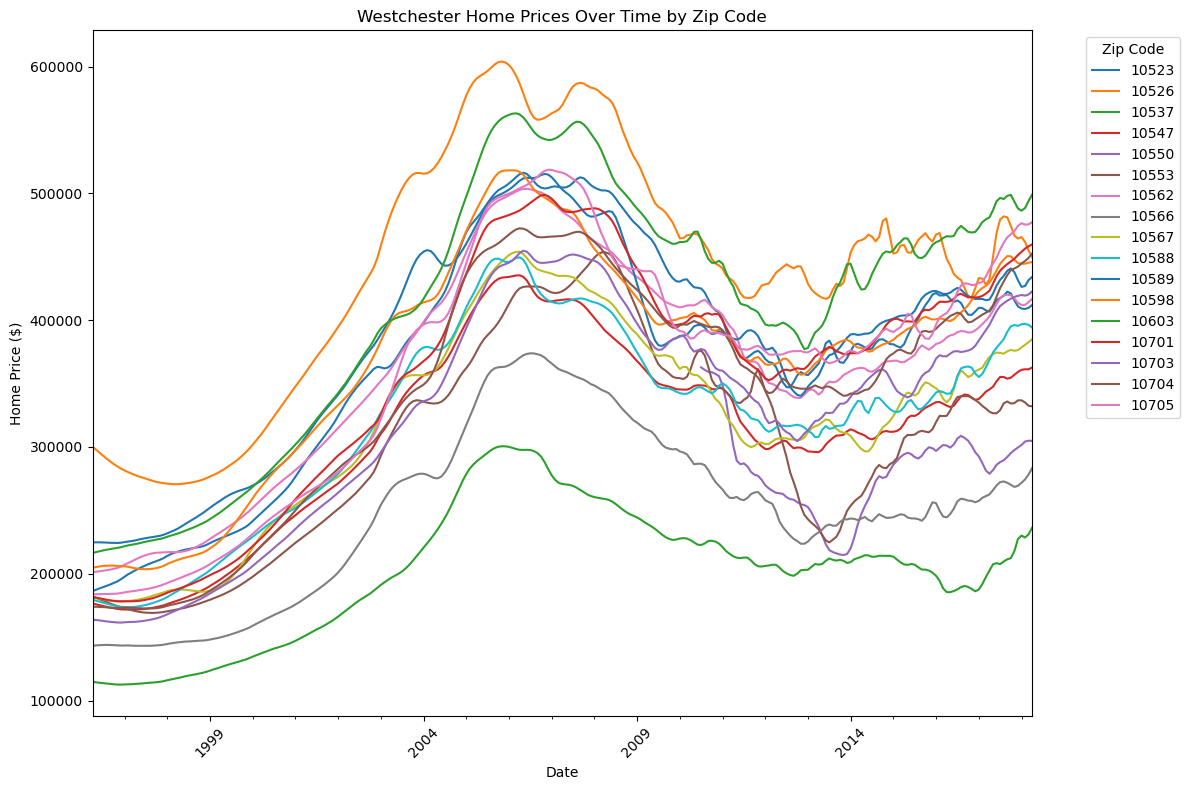

In [37]:
# Plot Home prices over time
    
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y-%m')

# Pivot the DataFrame so that each Zipcode has its own column with HomePrices as the values
pivot_df = melted_df.pivot(index='Date', columns='Zipcode', values='HomePrice')

# Plot home prices over time for each Zipcode
plt.figure(figsize=(12, 8))
pivot_df.plot(figsize=(12, 8))

plt.title('Westchester Home Prices Over Time by Zip Code')
plt.xlabel('Date')
plt.ylabel('Home Price ($)')
plt.legend(title='Zip Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Check for nulls
melted_df.isna().sum()

RegionID        0
Zipcode         0
City            0
State           0
Metro           0
CountyName      0
SizeRank        0
Date            0
HomePrice     171
dtype: int64

In [39]:
melted_df.HomePrice.fillna(method='bfill', inplace=True)

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_6092\2001961982.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  melted_df.HomePrice.fillna(method='bfill', inplace=True)
C:\Users\hrcoh\AppData\Local\Temp\ipykernel_6092\2001961982.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  melted_df.HomePrice.fillna(method='bfill', inplace=True)


In [40]:
melted_df.isna().sum()

RegionID      0
Zipcode       0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
Date          0
HomePrice     0
dtype: int64

In [ ]:
# Calculate ROI by zipcode
roi_df = nyc_df_melted.groupby('Zipcode').agg(
    StartPrice=('HomePrice', 'first'),
    EndPrice=('HomePrice', 'last')
).reset_index()
roi_df['ROI'] = ((roi_df['EndPrice'] - roi_df['StartPrice']) / roi_df['StartPrice']) * 100

# Merge ROI data back to the original dataframe
nyc_df_melted = nyc_df_melted.merge(roi_df[['Zipcode', 'ROI']], on='Zipcode', how='left')

# Get top 10 zip codes by size rank
top_10_zipcodes = nyc_df_melted['Zipcode'].unique()[:10]

# Set plot size and style
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

# Prepare data for bar chart
roi_top_10 = roi_df[roi_df['Zipcode'].isin(top_10_zipcodes)].sort_values(by='ROI', ascending=False)

# Get the order of Zipcodes based on descending ROI
zipcodes_order = roi_top_10['Zipcode']

# Vertical bar chart with manually set order
sns.barplot(x='Zipcode', y='ROI', data=roi_top_10, palette='Blues_r', order=zipcodes_order)

# Add labels and title
plt.title('ROI by Top 10 Zip Codes')
plt.xlabel('Zipcode')
plt.ylabel('ROI (%)')
plt.tight_layout()
plt.show()

In [ ]:
# Create a dictionary to hold the DataFrames for each Zipcode
zip_code_dfs = {zipcode: group for zipcode, group in nyc_df_melted.groupby('Zipcode')}

zip_code_dfs[11226]

In [ ]:
nyc_df_melted.set_index('Date', inplace=True)

In [ ]:
nyc_df_melted

In [ ]:
plt.figure(figsize=(14, 8))
ax = sns.lineplot(data=nyc_df_melted.reset_index(), x='Date', y='HomePrice', hue='Zipcode', palette='tab10')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.title('Home Price over Time by Zipcode')
plt.legend(title='Zipcode', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set major ticks to every 2 years
ax.xaxis.set_major_locator(mdates.YearLocator(2))
# Format the ticks to show only the year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate x-tick labels for clarity
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Make the model based on 

In [ ]:
nyc_df_melted.Zipcode

In [ ]:
# Dictionary to store ARIMA models and results
arima_results = {}
forecast_results = {}

In [ ]:
for zip_code, group in df.groupby('Zipcode'):
    try:
        # Ensure data is sorted by date
        group = group.sort_index()
        ts = group['HomePrice']

        # ADF test for stationarity
        result_original = adfuller(ts.dropna())
        
        # Determine differencing needed (d value for ARIMA)
        d = 0
        if result_original[1] >= 0.05:  # Non-stationary
            ts = ts.diff().dropna()
            d = 1

            # Recheck stationarity after first differencing
            result_diff = adfuller(ts)

            # If still non-stationary, apply second-order differencing
            if result_diff[1] >= 0.05:
                ts = ts.diff().dropna()
                d = 2

# Modeling

## Check if Data is Stationary

In [ ]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(ts)

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
ts_diff = ts.diff()
    
# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(ts_diff.dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.") 

## Arima Modeling

In [ ]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(ts_diff.dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(ts_diff.dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Forecasting

In [ ]:
# Split data into train and test
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [ ]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='red')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Home Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Evaluation

In [ ]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

In [ ]:
forecast = forecast[:len(test)]
test = test[:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.4f}")

## SARIMA

In [ ]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

In [ ]:
sari_mod =SARIMAX(train,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

In [ ]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

In [ ]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [ ]:
np.sqrt(mean_squared_error(test, y_hat_test))

## Forecast

In [ ]:
sari_mod = SARIMAX(ts_weekly,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [ ]:
forecast = sari_mod.forecast(steps=52)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ts_weekly, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Chicago Gun Crime Predictions\n One Year out')

plt.legend();

# Step 6: Interpreting Results